# Gradient Boosting Case Study
* Notebook completed by Adam Lang - Springboard Data Science Fellow
* Date: 5/5/2024

In [49]:
# library imports
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

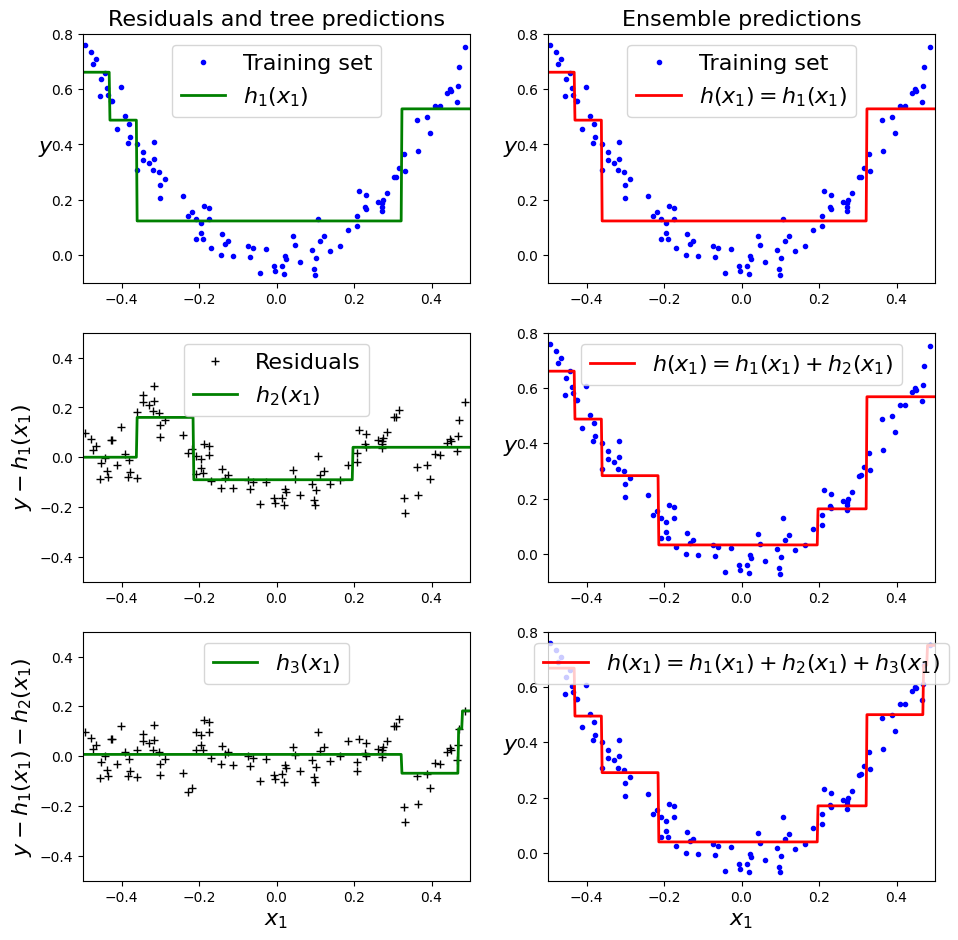

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
## upload titanic dataset
df = pd.read_csv('titanic.csv')

## df head
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Look at null/incomplete rows before we drop them

In [12]:
## null values
df.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

Looks like all the null values are in the Cabin and Age columns, we will drop them as recommended by the directions.

In [13]:
## drop all null values in the dataset
df = df.dropna()

In [14]:
## check null values again
df.isnull().sum().sort_values(ascending=False)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [16]:
# lets look at df.info() first
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


In [15]:
## print levels of categorical data using select_dtypes
df.select_dtypes(include=['object']).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [20]:
# Quick look at the values of the 'Sex' column and 'Embarked' column
print(df['Embarked'].value_counts())
print(df['Sex'].value_counts())

Embarked
S    116
C     65
Q      2
Name: count, dtype: int64
Sex
male      95
female    88
Name: count, dtype: int64


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [21]:
df = pd.DataFrame(df.drop(df.columns,axis =1)).merge(pd.get_dummies(df.drop(['Name','Cabin','Ticket','Sex','Embarked'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(183, 6)


,Survived,Pclass,Age,SibSp,Parch,Fare
1,1,1,38.0,1,0,71.2833
3,1,1,35.0,1,0,53.1000
6,0,1,54.0,0,0,51.8625
10,1,3,4.0,1,1,16.7000
11,1,1,58.0,0,0,26.5500


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [22]:
# print null values for each column in the dataframe
df.isnull().sum().sort_values(ascending=False)

Survived    0
Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [23]:
# print rows and columns in the dataframe
df.shape

(183, 6)

In [24]:
# create X and y matrices from dataframe where y=Survived
X = df.drop('Survived', axis=1)
y = df['Survived']

In [32]:
# print first 5 rows of X and y
print(f"First 5 rows of X:\n {X.head()}")
print("\n\n\n")
print(f"First 5 rows of y:\n {y.head()}")

First 5 rows of X:
     Pclass   Age  SibSp  Parch     Fare
1        1  38.0      1      0  71.2833
3        1  35.0      1      0  53.1000
6        1  54.0      0      0  51.8625
10       3   4.0      1      1  16.7000
11       1  58.0      0      0  26.5500




First 5 rows of y:
 1     1
3     1
6     0
10    1
11    1
Name: Survived, dtype: int64


**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [33]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [37]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
best_score = 0
best_rate = 0.05
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 42)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    #print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    validation_score = gb.score(X_test, y_test)
    print("Accuracy score (validation): {0:.3f}".format(validation_score))
    print()

    # loop to find the best learning rate
    if validation_score > best_score:
        best_score = validation_score
        best_rate = learning_rate
        best_model = gb
    print()

Learning rate:  0.05
Accuracy score (training): 0.745
Accuracy score (validation): 0.630


Learning rate:  0.1
Accuracy score (training): 0.788
Accuracy score (validation): 0.674


Learning rate:  0.25
Accuracy score (training): 0.847
Accuracy score (validation): 0.674


Learning rate:  0.5
Accuracy score (training): 0.898
Accuracy score (validation): 0.652


Learning rate:  0.75
Accuracy score (training): 0.920
Accuracy score (validation): 0.674


Learning rate:  1
Accuracy score (training): 0.964
Accuracy score (validation): 0.696




**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

Confusion matrix is:
 [[12  6]
 [ 8 20]]


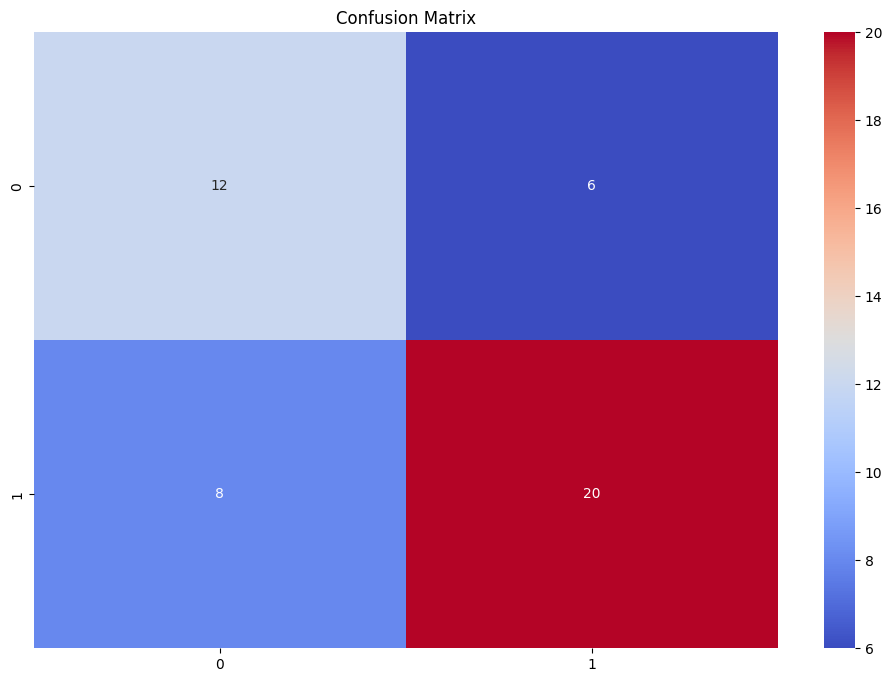

In [47]:
# apply best learning rate to the model fit and predict on the test set
y_pred = best_model.predict(X_test)


# print out confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix is:\n {cm}")


# print confusion matrix as heatmap
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm').set(title="Confusion Matrix")
plt.show();

Summary of Confusion Matrix results
* The goal of the model was to predict the target variable y 'Survived'.
* The results based on our confusion matrix show us:
    * 12 true positives (TP)
    * 6 false positives (FP)
    * 8 false negatives (FN)
    * 20 true negatives (TN)

* We could interpret this as:
    * There were 12 true positives and if we add the 8 false negatives we get 20 true positives.
    * There were 20 true negatives and if we add the 6 false positives we get 26 true negatives.

* Thus we could predict there were more passengers predicted not to survive.

In [43]:
# print out classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.77      0.71      0.74        28

    accuracy                           0.70        46
   macro avg       0.68      0.69      0.69        46
weighted avg       0.70      0.70      0.70        46



Summary of classification report:
* Let's recall that "1" is surviving and "0" is not surviving.
* The main findings of the report show us:
    * Out of all of the passengers the model predicted would survive (1), only 77% actually did.
        * On the flip side of this, of those the model predicted would not survive, 60% actually did not survive.
    * Out of all the passengers that actually survived (1), the model only predicted this outcome correctly for 71% of those passengers.
        * On the flip side of this, of the passengers that actually did not survive (0), the model only predicted this outcome correctly for 63% of the passengers, so not as great at predicting non-survival as survival of the passengers.
    * For the F1-score, the closer the value is to 1 the better the predictions are. The F1-score for survival is better than for non-survival at 0.74. So we can say that the model does a moderate job of predicting survival for the passengers, and with an F1-score of 0.63 for non-survival we can say the prediction ability is not that great or optimal.
    * The test set is represented by the `support` column and this shows us that 28 passengers were in the 1 survived and 18 in 0 not survived.

**<font color='teal'>Calculate the ROC for the model as well.</font>**

In [42]:
# Calculate ROC for model
y_scores = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC is: {round(roc_auc,3)}")

ROC AUC is: 0.703


In [58]:
## import ROCCurveDisplay
from sklearn.metrics import RocCurveDisplay

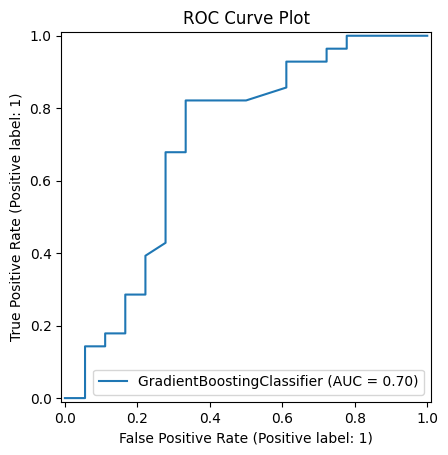

In [60]:
# plot roc curve
gb_disp = RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve Plot')
plt.show();

Summary of the ROC curve plot
* We know that the closer the ROC curve is to the upper left hand corner, the better the machine learning model is at predicting the target variable (survived the titantic). Obviously here we can see the plot of the AUC (Area under the curve) which we know is 70%, so we could say our model is only moderately good at predicting a passengers survival.